In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

2024-05-26 11:24:05.954308: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 11:24:06.006616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("validation.csv")

In [3]:
train.head()


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,6c274d3678353b62f5d3465c771e4a8c5cd917186a5323...,common_voice_bn_30991326.mp3,বাবা সত্যেন ঘোষ।,1.0,1.0,NaN,NaN,NaN,bn
1,3991c2cfe1be64e77f2f6bdaeaae601219af906c1295cd...,common_voice_bn_30991371.mp3,দেওয়ান ফরিদ গাজী বাংলাদেশ আওয়ামী লীগের উপদেষ...,1.0,0.0,NaN,NaN,NaN,bn
2,3991c2cfe1be64e77f2f6bdaeaae601219af906c1295cd...,common_voice_bn_30991410.mp3,এর মাধ্যমে কারও গান গাওয়া দক্ষতা বা নিজস্ব ধর...,0.0,0.0,NaN,NaN,NaN,bn
3,08cb638755d8adbe55e3149211af88853e0d77785397f9...,common_voice_bn_30991432.mp3,"আপনি খুব একটা কথা বলার লোক নন, তাই না?",0.0,0.0,NaN,NaN,NaN,bn
4,51215b6882d5fdc8a9856b095793244085341470a888f5...,common_voice_bn_30991478.mp3,"আপনি খুব একটা কথা বলার লোক নন, তাই না?",0.0,0.0,NaN,NaN,চট্টগ্রামের ভাষার সামান্য টানসহ মোটামুটি প্রমি...,bn


In [4]:
train = train[["path","sentence"]]
val = valid[["path","sentence"]]

In [5]:
print(f"Size of the training set: {len(train)}")
print(f"Size of the training set: {len(valid)}")

Size of the training set: 206950
Size of the training set: 7747


Preprocessing

In [6]:
characters = [x for x in ['।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঋ', 'এ', 'ঐ', 'ও', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'য়', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯',' ']]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', '।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঋ', 'এ', 'ঐ', 'ও', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ড়', 'য়', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', ' '] (size =72)


2024-05-26 11:24:19.218728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18440 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-05-26 11:24:19.219282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11339 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:b3:00.0, compute capability: 6.1


In [7]:
# An integer scalar Tensor. The window length in samples.
frame_length = 200
# An integer scalar Tensor. The number of samples to step.
frame_step = 80
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 256


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    #label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [8]:
# Collecting training filenames

import os
filenames = os.listdir("train_files_wav")

In [9]:
train["path"] = train["path"].apply(lambda x:x.replace(".mp3",".wav"))

In [10]:
from tqdm import tqdm

df = train.iloc[:len(filenames)]
to_take = []
label = []

for i in tqdm(range(len(train))):
    if train.path.iloc[i] in filenames:
        to_take.append(train.path.iloc[i])
        label.append(train.sentence.iloc[i])
df.path = to_take
df.sentence = label

train = df
print(train.shape)
train.head()

  0%|          | 178/206950 [00:00<01:56, 1771.47it/s]

100%|██████████| 206950/206950 [02:01<00:00, 1700.95it/s]

(37404, 2)



/tmp/ipykernel_496778/961359837.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.path = to_take
/tmp/ipykernel_496778/961359837.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sentence = label


,path,sentence
0,common_voice_bn_30991371.wav,দেওয়ান ফরিদ গাজী বাংলাদেশ আওয়ামী লীগের উপদেষ...
1,common_voice_bn_30991513.wav,ডিজিটাল বিশ্বে তথ্য অন্য যে কোনও ডিজিটাল ফাইলে...
2,common_voice_bn_30991535.wav,হিসাব পাওয়ার পর তিনি স্বল্প সময়ের মধ্যেই সম্...
3,common_voice_bn_30991543.wav,ডিজিটাল বিশ্বে তথ্য অন্য যে কোনও ডিজিটাল ফাইলে...
4,common_voice_bn_30991549.wav,"নিও এবং বেন ""হ্যামার"" জাহাজের মেডিকেল উপসাগরে ..."


In [11]:
val["path"] = val["path"].apply(lambda x:x.replace(".mp3",".wav"))
val.path.head()

/tmp/ipykernel_496778/2314818815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["path"] = val["path"].apply(lambda x:x.replace(".mp3",".wav"))


0    common_voice_bn_31621610.wav
1    common_voice_bn_31621614.wav
2    common_voice_bn_31600766.wav
3    common_voice_bn_31600769.wav
4    common_voice_bn_31513081.wav
Name: path, dtype: object

In [12]:
wavs_path = "train_files_wav/"

batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train["path"]), list(train["sentence"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

wavs_path = "validation_files_wav/"
# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(val["path"]), list(val["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2024-05-26 11:42:53.913730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64
	 [[{{node Placeholder/_4}}]]
2024-05-26 11:42:53.914272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [37404]
	 [[{{node Placeholder/_0}}]]


দেওয়ান ফরিদ গাজী বাংলাদেশ আওয়ামী লীগের উপদেষ্টা পরিষদের সদস্য ও মুক্তিযুদ্ধের সংগঠক ছিলেন।
tf.Tensor(16000, shape=(), dtype=int32)


/home/jlg/michele/miniforge3/envs/ctc/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2470 (\N{BENGALI LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jlg/michele/miniforge3/envs/ctc/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jlg/michele/miniforge3/envs/ctc/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jlg/michele/miniforge3/envs/ctc/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2451 (\N{BENGALI LETTER O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jlg/michele/miniforge3/envs/ctc/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2479 (

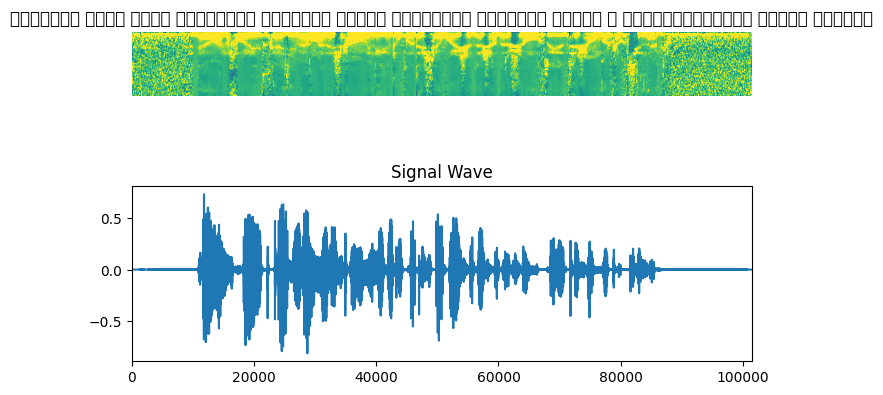

In [13]:
wavs_path = "train_files_wav/"

fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    print(label)
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(train["path"])[0])
    audio, _ = tf.audio.decode_wav(file)
    print(_)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [14]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    print(input_length,label_length)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [15]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=128,
)
model.summary(line_length=110)

ValueError: The channel dimension of the inputs should be defined. The input_shape received is (None, None, 129, 1), where axis -3 (0-based) is the channel dimension, which found to be `None`.

In [18]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [19]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

2024-05-26 13:31:55.167095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype resource
	 [[{{node Placeholder/_3}}]]
2024-05-26 13:31:55.167432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [37404]
	 [[{{node Placeholder/_0}}]]
2024-05-26 13:31:55.382783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

Tensor("CTCLoss/mul:0", shape=(None, 1), dtype=int64) Tensor("CTCLoss/mul_1:0", shape=(None, 1), dtype=int64)


2024-05-26 13:31:56.753455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-26 13:31:57.045591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-26 13:31:57.445109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

Tensor("CTCLoss/mul:0", shape=(None, 1), dtype=int64) Tensor("CTCLoss/mul_1:0", shape=(None, 1), dtype=int64)


2024-05-26 13:31:59.473226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-26 13:31:59.747588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-26 13:32:00.022668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

   6/1169 [..............................] - ETA: 14:07:17 - loss: 1730.6735

KeyboardInterrupt: 

In [ ]:
predictions = []
targets = []
i=0
for batch in tqdm(validation_dataset):
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    print(batch_predictions)
    i+=1
    if i>5:
        break
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

In [ ]:
test = pd.read_csv("../input/dlsprint/sample_submission.csv")


In [ ]:
test.path = test.path.apply(lambda x:x.replace(".mp3",".wav"))
test.head()

In [ ]:
wavs_path = "../input/test-wav-files-dl-sprint/test_files_wav/"


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(test["path"]), list(test["sentence"]))
)
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
predictions = []
targets = []
for batch in tqdm(validation_dataset):
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")